### Data dictionary:

Index: Row index 

user id: User ID (unique)

test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement

converted: If a person bought the product then True, else is False

total ads: Amount of ads seen by person

most ads day: Day that the person saw the biggest amount of ads

most ads hour: Hour of day that the person saw the biggest amount of ads

In [1]:
import pandas as pd 

df = (pd.read_csv('marketing_AB.csv')).drop('Unnamed: 0', axis=1)
df.converted = df.converted.astype(int)
df

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,0,1,Tuesday,23
588097,1327975,ad,0,1,Tuesday,23
588098,1038442,ad,0,3,Tuesday,23
588099,1496395,ad,0,1,Tuesday,23


In [2]:
from summarytools import dfSummary
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,user id[int64],Mean (sd) : 1310692.2 (202226.0)min < med < max:900000.0 < 1313725.0 < 1654483.0IQR (CV) : 340898.0 (6.5),"588,101 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3dO4/aQBSG4TOQReYSW1wCHU3K7ZBoaNKlzI9Nmy4FSKkp0qSiQUgIjCCLwsUpkihVWOwxi7/ofdrVMLP2KyRLHNklSWJA0ZXufQDgGq/ufYBbcc5Vzazi8RE/kiR5yus817rnuXPYu2Rm54xrL5670KF6XLig1Wq9j6KonnXv9Xq9dc59MrN9huVZb9g9z+219+l0etjtdm8bjca3Uql0SLt+s9msnHMf/xVrYUN1zlXb7faHMAybadceDofAzB6Hw+GXTqezSbt+Pp+/nkwm7/r9fqdcLqe64T437J7n9t17Nps1p9Ppm8Fg8LXX663SrI3jOBiPx83lclkxM61QzawShmFzNBo9RVGU6qL/vmi1IAgO3W73e9qNV6tVNQiC2mAw2Ke96D43rADn9trbzKxer++zrDez6qU/FjlUMzOLoij1P/7novnKctF9blgRzl1UPPVDAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCwk1/4e851Riez+eHPM8DXTcL1Wc4z+zXsNnpdHrc7/efzSzLDA7+I7f8Rs08nGf2d9jseDyWb3E4aLn5cF+W4Tyz4g+b4WXxMAUJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJz/7C32NAj+E85OZiqL5vz2M4D3l57hvV++15DOchD1cN993z7XmAGQ9TEEGokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokHDVcF8cx0HaD95ut4GZ2W63CxaLRe0l16vurXpu3/XX9PUTam1C2vGaU64AAAAASUVORK5CYII="">",0(0.0%)
2,test group[object],1. ad2. psa,"564,577 (96.0%)23,524 (4.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOUlEQVR4nO3bMWrDMBiG4V/FhGaRMAYfxofoYXsI3cYYa2hCFnXoVGMZYppPoL7P6OkfXgwJ/lzO2QAFZ2ZXM7vUPgRNeeScb9uH3TAMH977vsZFaFNKaXHOfW6D67z3/TRNtxDCvdZxaMe6ru8xxn6e54uZ/Y7NzCyEcB/H8avKdWjRde/hm/oK/F/EBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIdGY/H7zVPgRtOGqpSyktMcbeCh+8Ac9KKS1m9tg+Z/CCV9gdvDimfFA5erPt1gmcVZzyleZYwFm7U76jORZw1tGUj1+n+FP8qQsZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZHanfEz78ArFKV9pjgWcxeAFMt8KW2rfzqzdbgAAAABJRU5ErkJggg=="">",0(0.0%)
3,converted[int64],1. 02. 1,"573,258 (97.5%)14,843 (2.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElEQVR4nO3bMYqDQBiG4X8WCZtmBhE8jIfYw+4h5jYiTrEJaWaLIKzGLvoNzL5PZ/cXL0KCn8s5G6DgzOxqZpfSh6BKj5zzbXlouq778t63JS9CnVJKk3Puewmu8d63wzDcQgj30sehHvM8f8YY23EcL2b2jM3MLIRw7/v+p+h1qNH178NHqSvw/xAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CDTmD0/dCt9COqy11STUppijK1tPnQD3pVSmszssTwzeMGZVoMXx5QPKntvtlWNwFFepnzb+RVwlNWUb29+BRxlb8rHr1Kcgj91IUNskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoPMasrHpA9nepnybedXwFEYvEDmFwpbat8xTAwqAAAAAElFTkSuQmCC"">",0(0.0%)
4,total ads[int64],Mean (sd) : 24.8 (43.7)min < med < max:1.0 < 13.0 < 2065.0IQR (CV) : 23.0 (0.6),807 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABk0lEQVR4nO3XwWoaUQCF4XtrKnHRGURw6SP0AXyIPGy23fssbqSOlGojcrPLJqTGSUt74PvWcw8X5mfE2lor8L/79K8vAO9xd+2BWuuslDIduf/UWjuOPAsvfhtqrXW2WCweuq6bjxk/HA7fa62PYuWjrn1Rp13Xzdfr9bHv+9Mtw8Mw3G82m/lut5uWUoTKh1z96S+llL7vT8vl8ueI/dmIM/CKP1NEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoR7v7m+OVy+VxK6WqtYyeeWmvHP3glQr0r1GEY7m8d3m63X87n89fVajWZTCan269Wyn6//1Fr/VZKGXWeKL9aa2++52fxYDzEnB/1ZAAAAABJRU5ErkJggg=="">",0(0.0%)
5,most ads day[object],1. Friday2. Monday3. Sunday4. Thursday5. Saturday6. Wednesday7. Tuesday,"92,608 (15.7%)87,073 (14.8%)85,391 (14.5%)82,982 (14.1%)81,660 (13.9%)80,908 (13.8%)77,479 (13.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bG

In [3]:
treatment_count = df[df['test group'] == 'ad'].shape[0]
control_count = df[df['test group'] == 'psa'].shape[0]

print(f"Number of treatment IDs: {treatment_count}")
print(f"Number of control IDs: {control_count}")

Number of treatment IDs: 564577
Number of control IDs: 23524


Making balanced groups and grouping the data by test group

In [4]:
treatment_group = df[df['test group'] == 'ad']
control_group = df[df['test group'] == 'psa']

treatment_group = treatment_group.sample(23524)

print(treatment_group.info())
print('')
print(control_group.info())

balanced_df = pd.concat([treatment_group, control_group], axis=0)

balanced_df

<class 'pandas.core.frame.DataFrame'>
Index: 23524 entries, 149429 to 243810
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user id        23524 non-null  int64 
 1   test group     23524 non-null  object
 2   converted      23524 non-null  int64 
 3   total ads      23524 non-null  int64 
 4   most ads day   23524 non-null  object
 5   most ads hour  23524 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.3+ MB
None

<class 'pandas.core.frame.DataFrame'>
Index: 23524 entries, 18 to 588081
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user id        23524 non-null  int64 
 1   test group     23524 non-null  object
 2   converted      23524 non-null  int64 
 3   total ads      23524 non-null  int64 
 4   most ads day   23524 non-null  object
 5   most ads hour  23524 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 

,user id,test group,converted,total ads,most ads day,most ads hour
149429,1544439,ad,0,49,Wednesday,12
264042,1527247,ad,0,11,Tuesday,12
97800,1104395,ad,0,148,Wednesday,20
535903,1133747,ad,1,9,Tuesday,15
219238,1554095,ad,0,33,Monday,11
...,...,...,...,...,...,...
588052,900959,psa,0,16,Tuesday,22
588063,902828,psa,0,3,Tuesday,22
588066,914578,psa,0,1,Tuesday,22
588069,909042,psa,0,6,Tuesday,22


In [5]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(balanced_df['test group'], balanced_df['converted'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2}, P-value: {p}")

Chi-square: 33.76587608634707, P-value: 6.215968515385182e-09


most ads day
Friday       0.022212
Monday       0.032812
Saturday     0.021051
Sunday       0.024476
Thursday     0.021571
Tuesday      0.029840
Wednesday    0.024942
Name: converted, dtype: float64


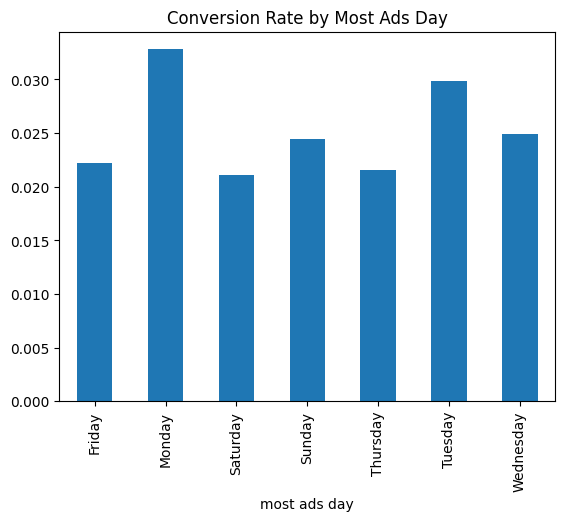

Chi-square: 42.651338222771216, P-value: 1.3671903877429804e-07


In [7]:
import matplotlib.pyplot as plt
# Conversion rate by day
conversion_by_day = df.groupby('most ads day')['converted'].mean()
print(conversion_by_day)

# Plot conversion rates by day and hour
conversion_by_day.plot(kind='bar', title='Conversion Rate by Most Ads Day')
plt.show()

cont_table_days = pd.crosstab(balanced_df['most ads day'], balanced_df['converted'])
# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(cont_table_days)
print(f"Chi-square: {chi2}, P-value: {p}")

In [39]:
import statsmodels.api as sm

# Prepare the data
X = df[['total ads']]  # Independent variable: total ads seen
y = df['converted']    # Dependent variable: conversion (0 or 1)

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print the summary of the logistic regression
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.109041
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               588101
Model:                          Logit   Df Residuals:                   588099
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Aug 2024   Pseudo R-squ.:                 0.07421
Time:                        19:52:58   Log-Likelihood:                -64127.
converged:                       True   LL-Null:                       -69267.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0541      0.010   -403.485      0.000      -4.074      -4.034
total ads      0.0101   9.85e